1. Annotate w/ laclip 
2. Annotate w/ reason for pathology missing 
3. annotate for the reason that the imaging might be missing
4. Substitution of 0's for NA's, Annotate those substitutions, find where quant failed for perf
5. Annotates for inclusion of modalities 
6. Imputes b1000 data from b2000 using linear modeling 
7. Adds in output from get_igt_stats.ipynb, w/ %CEL, NEL, NEC & inclusion criteria (can be found in DataWrangling/GetMergeData/)
8. Excludes ependymomas and other non-astro non-oligo HGGs (desired_hist) 
9. Creates outcome labels (multnom_out), adds necrosis, makes PN category (pathologically normal) that are in CEL or in the NEL region labeled TxE  
12. Adds in binary operator to include the data only if it's rHGG or TxE 


In [1]:
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

## 1. LacLip Annotation

In [2]:
getwd()

[1] "/home/sf673542/DataWrangling/AnnotateData"

In [3]:
all_recgli = read.csv("../GetMergeData/Oct2018/researchPath_withInVivoData_REC_HGG.csv")
dim(all_recgli)

[1] 324  41

In [4]:
laclip = ifelse(all_recgli$nlac == all_recgli$nlip, 1, 0)
table(laclip)
laclip_values = ifelse(laclip==1, all_recgli$nlac, all_recgli$nlac+all_recgli$nlip)
all_recgli$laclip = laclip_values

laclip
  0   1 
 44 174 

In [5]:
colnames(all_recgli)

[1] "b_number"                 "t_number"                
 [3] "sf_number"                "current_scan_date"       
 [5] "current_surgery_date"     "current_hist_grade"      
 [7] "current_hist_type"        "roi.label"               
 [9] "tumor_cell_evaluation"    "necrosis"                
[11] "mv_hyperplasia"           "f8_delicate"             
[13] "f8_simple"                "f8_complex"              
[15] "mib_1"                    "avgerage_cells"          
[17] "bx_pure_treatment_effect" "percent_tumor_nuclei"    
[19] "nfse"                     "nfl"                     
[21] "nt1c"                     "nt1v"                    
[23] "nt1d"                     "nadc.1"                  
[25] "nfa.1"                    "nadc.2"                  
[27] "nfa.2"                    "phn_nlin"                
[29] "cbvn_nlin"                "recov_nlin"              
[31] "phn_npar"                 "recov_npar"              
[33] "recovn_npar"              "cni"                     
[35] "ccri"                     "crni"                    
[37] "ncho"                     "ncre"                    
[39] "nnaa"                     "nlip"                    
[41] "nlac"                     "laclip"

In [6]:
write.csv(all_recgli, file = "REC_HGG_Annotation_Oct2018/Annot1_researchPath_withInVivoData.csv", row.names = F)

## 2. Pathology Comments For Outcome Determination

In [7]:
all_recgli = read.csv("REC_HGG_Annotation_Oct2018/Annot1_researchPath_withInVivoData.csv")

Here we have to go & download most recent pathology comment reports from cerebro. 
Go to https://braino.radiology.ucsf.edu/ncvi/secure/clinical/search/AdvancedSearch2.do?cid=5

1. For old data, click Search Criteria = Study tag equals P01_PREOP_REC
2. Under "Tissue Samples (Research)" Click "Tissue Bank Vial ID" 
3. Under "Pathology Events (Research)" Click "Pathology Comments" 
4. Click the green button to download, save as path_comments_oldP01.csv, & upload to CWD 
5. Repeat for new data, with Search Criteria = Study tag equals REC_HGG, save as path_comments_RECHGG.csv 

In [9]:
newpathcomments = read.csv("path_comments_RECHGG.csv")
dim(newpathcomments)

[1] 417   2

Previously I had looked at old spreadsheets and determined that there was no FFPE tissue and I annotated that in a file called no_path_in_data.csv. I moved that to CWD and will upload now: 

In [10]:
no_ffpe_determination_by_julia = read.csv("no_path_in_data.csv")
colnames(no_ffpe_determination_by_julia)[4]="roi.label"
colnames(oldpathcomments)=c('roi.label', 'comments')
colnames(newpathcomments)=c('roi.label', 'comments')

In [11]:
allpathcomments = rbind(oldpathcomments, newpathcomments)
dim(allpathcomments)
allpathcomments[,1]=as.character(allpathcomments[,1])
all_recgli$roi.label=as.character(all_recgli$roi.label)

[1] 788   2

In [12]:
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [13]:
table(duplicated(allpathcomments$roi.label))
which(duplicated(allpathcomments))
allpathcomments=allpathcomments[-which(duplicated(allpathcomments)),]
dim(allpathcomments)


FALSE  TRUE 
  675   113 

[1] 373 374 375 376 377 382 386 391 392 395 400 401 405 406 409 414 419 420
 [19] 423 428 431 435 439 442 446 450 453 456 460 465 470 474 478 482 484 488
 [37] 493 497 501 509 511 516 517 518 521 525 528 537 542 545 550 555 559 563
 [55] 568 571 576 581 586 587 592 595 600 605 612 617 626 631 634 638 647 649
 [73] 650 655 664 665 666 667 668 671 675 679 682 687 692 697 702 703 706 711
 [91] 714 718 721 724 727 731 733 736 741 746 747 752 757 760 761 766 770 773
[109] 777 780 785 786 788

[1] 675   2

In [14]:
recgli.withpathcommments = left_join(all_recgli, allpathcomments, by = "roi.label")

In [15]:
dim(recgli.withpathcommments)

[1] 324  43

In [16]:
table(duplicated(no_ffpe_determination_by_julia$roi.label))
recgli = left_join(recgli.withpathcommments, no_ffpe_determination_by_julia[,c(4,8)], by = "roi.label")


FALSE 
   77 

Warning message:
“Column `roi.label` joining character vector and factor, coercing into character vector”

In [18]:
head(recgli, n = 20 )

b_number,t_number,sf_number,current_scan_date,current_surgery_date,current_hist_grade,current_hist_type,roi.label,tumor_cell_evaluation,necrosis,mv_hyperplasia,f8_delicate,f8_simple,f8_complex,mib_1,avgerage_cells,bx_pure_treatment_effect,percent_tumor_nuclei,nfse,nfl,nt1c,nt1v,nt1d,nadc.1,nfa.1,nadc.2,nfa.2,phn_nlin,cbvn_nlin,recov_nlin,phn_npar,recov_npar,recovn_npar,cni,ccri,crni,ncho,ncre,nnaa,nlip,nlac,laclip,comments,notes.
1338,8773,9727,2013-10-02,2013-10-03,Grade IV,Glioblastoma,60B60,1,0,0,,,,2.01,99,f,5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA
1338,8773,9727,2013-10-02,2013-10-03,Grade IV,Glioblastoma,61B60,3,0,1,,,,70.25,158,f,90,1.51,1.74,0.91,NA,NA,1.42,0.54,NA,NA,1.21,1.38,100.00,1.20,100.00,100.00,10.10,8.76,1.93,3.45,1.36,0.72,0.54,0.35,0.89,,NA
1338,8773,9727,2013-10-02,2013-10-03,Grade IV,Glioblastoma,62B60,2,0,2,,,,62.61,176,f,25,1.58,1.75,1.29,NA,NA,1.53,0.75,NA,NA,1.02,1.38,100.00,1.10,100.00,100.00,6.00,6.16,0.33,2.19,0.59,0.50,0.39,0.62,1.01,,NA
1338,8773,9727,2013-10-02,2013-10-03,Grade IV,Glioblastoma,63B60,2,0,1,,,,59.98,261,f,65,1.22,1.18,0.92,NA,NA,1.13,0.54,NA,NA,1.29,1.80,95.57,1.43,100.00,100.00,8.70,5.26,3.33,2.93,1.80,0.80,0.66,0.38,1.04,,NA
2947,8775,9729,2013-10-06,2013-10-07,Grade IV,Glioblastoma,1B61,2,0,0,,,,34.83,364,t,75,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.70,4.88,88.72,3.62,93.68,100.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA
2947,8775,9729,2013-10-06,2013-10-07,Grade IV,Glioblastoma,2B61,3,0,2,,,,18.50,256,f,95,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.03,3.82,100.00,2.77,100.00,100.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA
2947,8775,9729,2013-10-06,2013-10-07,Grade IV,Glioblastoma,3B61,2,0,0,,,,17.50,270,t,75,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.76,2.57,88.01,1.83,95.04,100.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA
2947,8775,9729,2013-10-06,2013-10-07,Grade IV,Glioblastoma,4B61,2,0,1,,,,8.62,203,f,75,NA,NA,NA,NA,NA,NA,NA,NA,NA,2.14,2.17,81.89,2.10,87.26,100.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA
3472,8783,9739,2013-10-14,2013-10-15,Treatment Effect,Treatment Effect,31B61,1,0,1,,,,1.13,198,t,20,1.08,1.38,0.97,NA,NA,1.05,1.12,1.18,1.50,1.07,0.98,99.97,0.99,100.00,100.00,4.10,2.00,1.54,1.59,1.04,0.52,0.13,0.30,0.43,,not in any path_report on Box
3472,8783,9739,2013-10-14,2013-10-15,Treatment Effect,Treatment Effect,33B61,1,0,0,,,,1.34,242,f,20,1.23,1.61,1.92,NA,NA,1.38,0.58,1.28,0.94,0.90,0.94,95.56,0.94,100.00,100.00,2.60,0.70,1.44,1.24,1.04,0.56,0.65,0.25,0.90,,not in any path_report on Box


In [19]:
write.csv(recgli, "REC_HGG_Annotation_Oct2018/2ndAnnot_researchPath_withInVivo.csv", row.names=F)

## 3. Reason that Imaging is Missing 

In [20]:
all_recgli = read.csv("REC_HGG_Annotation_Oct2018/2ndAnnot_researchPath_withInVivo.csv")

Remove the spaces in the roi.label column in order to match our vialIDs from the missingDataReasons

In [21]:
all_recgli$roi.label = gsub(" ", "", as.character(all_recgli$roi.label))

Earlier I had written up why imaging was missing for old data and for new data. I copied the files called "REC_HGG_missingImagingNotes.csv" and "olddata_Nelson_missingDataReasons.csv" to this directory.

In [22]:
new_missingImaging = read.csv("REC_HGG_missingImagingNotes.csv")
new_missingImaging

bnum,tnum,sfnum,screenshots_unavailable,tissue_consent
b971,10668,10943,0,0
b4210,10768,11037,0,0
b4193,11747,11485,0,0
b2678,9386,*,0,1
b4166,10643,*,0,1
b1335,11420,*,0,1
b4330,11596,*,0,1
b4161,11424,*,0,1
b4209,10766,**,0,1
b3537,8969,**,0,1


In [23]:
all_recgli = data.frame(all_recgli, imaging_code = NA)

In [24]:
for (tnum in unique(new_missingImaging$tnum)){
    line = new_missingImaging[new_missingImaging$tnum == tnum, ]
    if (line$tissue_consent==1 && tnum %in% all_recgli$t_number){
        all_recgli[all_recgli$t_number == tnum,]$imaging_code = "tiss_cons"
    }
}

In [25]:
for (tnum in unique(new_missingImaging$tnum)){
    line = new_missingImaging[new_missingImaging$tnum == tnum, ]
    if (line$screenshots_unavailable==1 && tnum %in% all_recgli$t_number){
        all_recgli[all_recgli$t_number == tnum,]$imaging_code = "scrn"
    }
}

In [26]:
table(all_recgli$imaging_code)


     scrn tiss_cons 
       13        16 

In [27]:
all_recgli[which(is.na(all_recgli$nfse) & is.na(all_recgli$imaging_code)),]$imaging_code = "biopsy_quant"

In [28]:
table(all_recgli$imaging_code)


biopsy_quant         scrn    tiss_cons 
          25           13           16 

In [31]:
all_recgli[which(all_recgli$imaging_code == "biopsy_quant"), ]

,b_number,t_number,sf_number,current_scan_date,current_surgery_date,current_hist_grade,current_hist_type,roi.label,tumor_cell_evaluation,necrosis,mv_hyperplasia,f8_delicate,f8_simple,f8_complex,mib_1,avgerage_cells,bx_pure_treatment_effect,percent_tumor_nuclei,nfse,nfl,nt1c,nt1v,nt1d,nadc.1,nfa.1,nadc.2,nfa.2,phn_nlin,cbvn_nlin,recov_nlin,phn_npar,recov_npar,recovn_npar,cni,ccri,crni,ncho,ncre,nnaa,nlip,nlac,laclip,comments,notes.,imaging_code
1,1338,8773,9727,2013-10-02,2013-10-03,Grade IV,Glioblastoma,60B60,1,0,0,,,,2.01,99,f,5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,biopsy_quant
5,2947,8775,9729,2013-10-06,2013-10-07,Grade IV,Glioblastoma,1B61,2,0,0,,,,34.83,364,t,75,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.70,4.88,88.72,3.62,93.68,100.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,biopsy_quant
6,2947,8775,9729,2013-10-06,2013-10-07,Grade IV,Glioblastoma,2B61,3,0,2,,,,18.50,256,f,95,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.03,3.82,100.00,2.77,100.00,100.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,biopsy_quant
7,2947,8775,9729,2013-10-06,2013-10-07,Grade IV,Glioblastoma,3B61,2,0,0,,,,17.50,270,t,75,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.76,2.57,88.01,1.83,95.04,100.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,biopsy_quant
8,2947,8775,9729,2013-10-06,2013-10-07,Grade IV,Glioblastoma,4B61,2,0,1,,,,8.62,203,f,75,NA,NA,NA,NA,NA,NA,NA,NA,NA,2.14,2.17,81.89,2.10,87.26,100.00,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,biopsy_quant
12,3499,8869,9795,2013-12-10,2013-12-11,Grade IV,Glioblastoma,68B60,3,0,2,,,,52.39,369,f,95,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,"""POORLY DIFFERENTIATED REGION""",NA,biopsy_quant
59,1957,9134,10071,2014-08-12,2014-08-13,Grade III,Oligodendroglioma,15B71,,NA,,,,,NA,NA,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,biopsy_quant
72,3486,9287,NA,2014-12-16,2014-12-17,Grade IV,Glioblastoma,,,NA,,,,,NA,NA,,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,biopsy_quant
82,3528,9408,10205,2014-12-22,2014-12-23,Grade III,Oligodendroglioma,54B75,1,0,0,,,,1.63,73,f,20,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,,NA,biopsy_quant
83,3528,9408,10205,2014-12-22,2014-12-23,Grade III,Oligodendroglioma,55B75,1,0,0,,,,0.90,177,f,10,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,"""P and CY appear to have XRT changes to cells""",NA,biopsy_quant


In [29]:
write.csv(all_recgli, "REC_HGG_Annotation_Oct2018/3rdAnnot_researchPath_withInVivo.csv", row.names = F)

## 4. Substitution of 0's for NA's, Annotate those substitutions, find where quant failed for perf

Since 0's mess up averages of different things, and they result from not properly quantitating the imaging parameters, we must eliminate them. However, these are indications of improper biopsy_quant problems, so we must annotate those before labeling them as NA. 

In [32]:
recgli = read.csv("REC_HGG_Annotation_Oct2018/3rdAnnot_researchPath_withInVivo.csv")

Perfusion: 

In [34]:
recgli = data.frame(recgli, perf_quant = NA )

In [35]:
str(recgli$phn_nlin)

 num [1:324] NA 1.21 1.02 1.29 3.7 3.03 1.76 2.14 1.07 0.9 ...


In [42]:
recgli$perf_quant = ifelse(recgli$phn_nlin > 20, "extreme_value", NA)

In [43]:
table(recgli$perf_quant)


extreme_value 
            3 

In [44]:
## here we're labeling perf_quant = 1 for those that have all zeros 
recgli$perf_quant[which(recgli$cbvn_nlin==0 &
                      recgli$phn_npar==0 & recgli$recovn_npar==0)] = "all_zeros"

In [45]:
table(recgli$perf_quant)


    all_zeros extreme_value 
           11             3 

In [46]:
## Now we want to substitute zero's for NAs where perf_quant has string value: 
recgli$phn_nlin = ifelse(!is.na(recgli$perf_quant), NA, recgli$phn_nlin)

Spectroscopy: 

In [47]:
recgli = data.frame(recgli, spec_quant = NA)

In [48]:
## here we're labeling perf_quant = 1 for those that have all zeros 
recgli$spec_quant = ifelse(recgli$cni==0 &
                      recgli$ccri==0 & recgli$nnaa==0 & 
                           recgli$ncho ==0 & recgli$ncre ==0, "all_zeros",NA)
table(recgli$spec_quant)
table(is.na(recgli$spec_quant))


all_zeros 
       39 


FALSE  TRUE 
   39   285 

In [49]:
recgli$cni[which(recgli$spec_quant=="all_zeros")]=NA
recgli$ccri[which(recgli$spec_quant=="all_zeros")]=NA
recgli$crni[which(recgli$spec_quant=="all_zeros")]=NA
recgli$ncho[which(recgli$spec_quant=="all_zeros")]=NA
recgli$ncre[which(recgli$spec_quant=="all_zeros")]=NA
recgli$nnaa[which(recgli$spec_quant=="all_zeros")]=NA
recgli$nlac[which(recgli$spec_quant=="all_zeros")]=NA
recgli$nlip[which(recgli$spec_quant=="all_zeros")]=NA
recgli$laclip[which(recgli$spec_quant=="all_zeros")]=NA

In [50]:
## We also want to know - how many of these had all biopsies fail per patient, 
## versus how many have individual biopsies that fail next to biopsies whose quantification succeeded? 

## NOTE: Follow up with this later. 

In [51]:
write.csv(recgli, file = "REC_HGG_Annotation_Oct2018/4thAnnot_researchPath_withInVivo.csv", row.names=F)

In [52]:
data.frame(index = 1:length(colnames(recgli)), colnames = colnames(recgli))

index,colnames
1,b_number
2,t_number
3,sf_number
4,current_scan_date
5,current_surgery_date
6,current_hist_grade
7,current_hist_type
8,roi.label
9,tumor_cell_evaluation
10,necrosis


## 5. Annotate with inclusion binary codes: 

In [53]:
all_recgli = read.csv("REC_HGG_Annotation_Oct2018/4thAnnot_researchPath_withInVivo.csv")
dim(all_recgli)

[1] 324  47

In [54]:
## now want to add binary operators of whether to include them 
imaging_issue = ifelse(is.na(all_recgli$imaging_code), 0, 1)
dim(all_recgli[imaging_issue==0,])
# [1] 527  50
table(is.na(all_recgli$nfse[imaging_issue==0]))

[1] 270  47


FALSE 
  270 

In [55]:
# FALSE 527
## so similar to our old data frame
include_anat = ifelse(is.na(all_recgli$nfse), 0, 1)
include_diffu1000 = ifelse(is.na(all_recgli$nadc.1) & is.na(all_recgli$nfa.1), 0, 1)
include_diffu2000 = ifelse(is.na(all_recgli$nadc.2) & is.na(all_recgli$nfa.2), 0, 1)
include_diffu_all = ifelse(include_diffu1000 == 1 | include_diffu2000 ==1, 1, 0)
include_perf = ifelse(grepl("[[:alpha:]]", all_recgli$perf_quant), 0, 1)
include_spec = ifelse(is.na(all_recgli$cni), 0, 1)

In [56]:
all_recgli.withbin = data.frame(all_recgli, include_anat=include_anat, include_diffu1000=include_diffu1000, 
                            include_diffu2000 = include_diffu2000, include_diffu_all = include_diffu_all, 
                            include_perf = include_perf, include_spec = include_spec)
all_recgli = all_recgli.withbin

one_advanced_mod = ifelse(include_diffu_all ==1 | include_perf == 1 | include_spec ==1, 1, 0)
include_one_advanced_mod = ifelse(include_anat == 1 & (include_diffu_all ==1 | include_perf == 1 | include_spec ==1) , 1, 0)
table(include_one_advanced_mod)
#   0   1 
# 118  521
all_recgli = data.frame(all_recgli, include_one_advanced_mod)
include_all_advanced_mods = ifelse(include_anat ==1 & include_diffu_all ==1 & include_perf == 1 & include_spec, 1, 0)
table(include_all_advanced_mods)
#  0   1 
# 445 194
all_recgli = data.frame(all_recgli, include_all_advanced_mods)

include_one_advanced_mod
  0   1 
 54 270 

include_all_advanced_mods
  0   1 
154 170 

In [57]:
write.csv(all_recgli, "REC_HGG_Annotation_Oct2018/5thAnnot_researchPath_withInVivoData.csv", row.names = F)

write.csv(all_recgli[all_recgli$tumor_cell_evaluation=="", c("t_number", "roi.label", "notes.")],file = "path_to_joanna.csv")

## 6. Imputing b1000 data from b2000 data:

In [58]:
recgli = read.csv("REC_HGG_Annotation_Oct2018/5thAnnot_researchPath_withInVivoData.csv")
dim(recgli)

[1] 324  55

In [59]:
colSums(is.na(recgli))

b_number                  t_number                 sf_number 
                        0                         0                        25 
        current_scan_date      current_surgery_date        current_hist_grade 
                        0                         0                         0 
        current_hist_type                 roi.label     tumor_cell_evaluation 
                        0                         0                         0 
                 necrosis            mv_hyperplasia               f8_delicate 
                       95                         0                         0 
                f8_simple                f8_complex                     mib_1 
                        0                         0                       105 
           avgerage_cells  bx_pure_treatment_effect      percent_tumor_nuclei 
                      110                         0                       103 
                     nfse                       nfl                      nt1c 
                       54                        54                        54 
                     nt1v                      nt1d                    nadc.1 
                       81                        81                       109 
                    nfa.1                    nadc.2                     nfa.2 
                      109                        61                        61 
                 phn_nlin                 cbvn_nlin                recov_nlin 
                      162                       148                       148 
                 phn_npar                recov_npar               recovn_npar 
                      148                       148                       148 
                      cni                      ccri                      crni 
                      145                       145                       145 
                     ncho                      ncre                      nnaa 
                      145                       145                       145 
                     nlip                      nlac                    laclip 
                      145                       145                       145 
                 comments                    notes.              imaging_code 
                        3                       254                       270 
               perf_quant                spec_quant              include_anat 
                      310                       285                         0 
        include_diffu1000         include_diffu2000         include_diffu_all 
                        0                         0                         0 
             include_perf              include_spec  include_one_advanced_mod 
                        0                         0                         0 
include_all_advanced_mods 
                        0

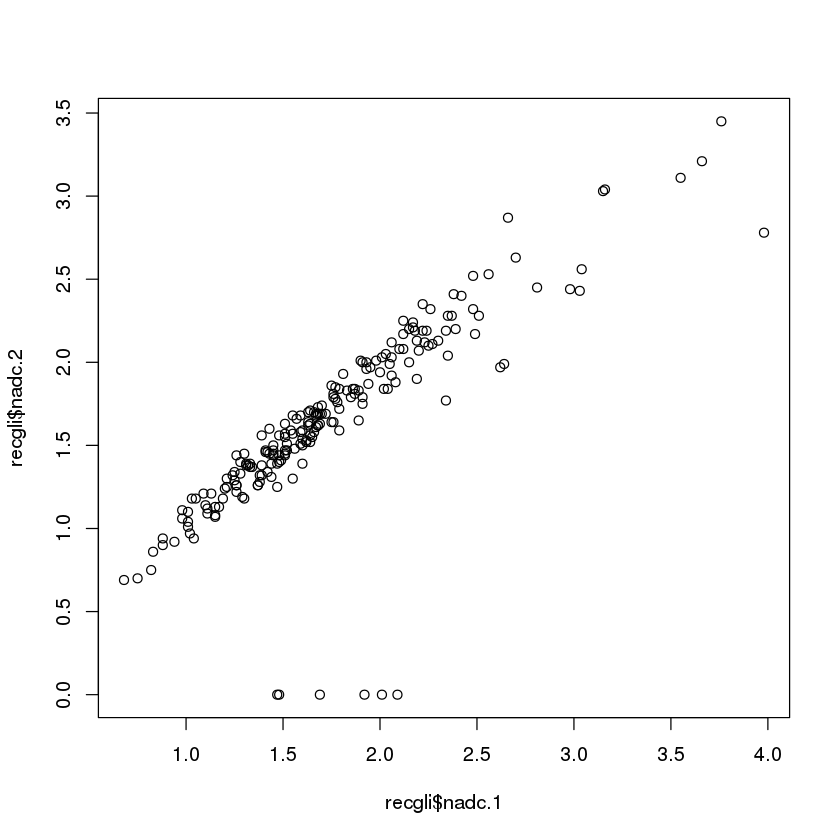

In [60]:
plot(recgli$nadc.1, recgli$nadc.2)

We want to create the most accurate linear approximation as possible, so we must remove the points for which it is clear that b=2000 quantification output a zero when it should have output a different number: 

In [61]:
recgli[which(recgli$nadc.2 ==0),]$nadc.2 = NA 
recgli[which(recgli$nfa.2 ==0),]$nfa.2 = NA 


In [62]:
diffu.fit = lm(nadc.1~nadc.2, data = recgli)
summary(diffu.fit)


Call:
lm(formula = nadc.1 ~ nadc.2, data = recgli)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40919 -0.09202 -0.02049  0.06146  1.01223 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.16484    0.03993  -4.128 5.37e-05 ***
nadc.2       1.12684    0.02268  49.685  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.154 on 200 degrees of freedom
  (122 observations deleted due to missingness)
Multiple R-squared:  0.9251,	Adjusted R-squared:  0.9247 
F-statistic:  2469 on 1 and 200 DF,  p-value: < 2.2e-16


In [63]:
nadc1from2 = predict(diffu.fit, newdata = recgli[which(is.na(recgli$nadc.1) & !is.na(recgli$nadc.2)),])
length(nadc1from2)
recgli$nadc.1[match(names(nadc1from2), rownames(recgli))]=nadc1from2

[1] 55

In [64]:
table(is.na(recgli$nadc.1))
table(is.na(recgli$nadc.2))
table(is.na(recgli$nadc.1), is.na(recgli$nadc.2))


FALSE  TRUE 
  270    54 


FALSE  TRUE 
  257    67 

       
        FALSE TRUE
  FALSE   257   13
  TRUE      0   54

In [65]:
table(is.na(recgli$nfa.1))
table(is.na(recgli$nfa.2))
table(is.na(recgli$nfa.1), is.na(recgli$nfa.2))


FALSE  TRUE 
  215   109 


FALSE  TRUE 
  257    67 

       
        FALSE TRUE
  FALSE   202   13
  TRUE     55   54

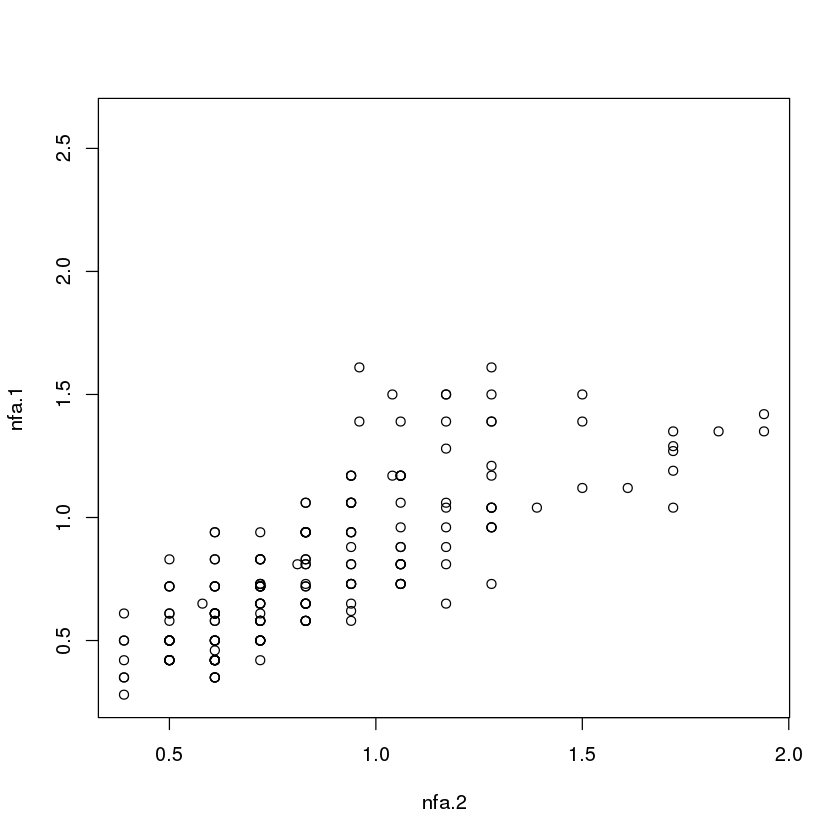

In [66]:
plot(nfa.1~nfa.2, data = recgli)

In [67]:
nfa.fit = lm(nfa.1~nfa.2, data = recgli)
summary(nfa.fit)


Call:
lm(formula = nfa.1 ~ nfa.2, data = recgli)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38625 -0.14123 -0.03824  0.11294  0.74464 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.15687    0.03894   4.029 7.95e-05 ***
nfa.2        0.73801    0.04267  17.295  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1935 on 200 degrees of freedom
  (122 observations deleted due to missingness)
Multiple R-squared:  0.5993,	Adjusted R-squared:  0.5973 
F-statistic: 299.1 on 1 and 200 DF,  p-value: < 2.2e-16


In [68]:
preds.nfa = predict(nfa.fit, newdata = recgli[which(is.na(recgli$nfa.1) & !is.na(recgli$nfa.2)),])
print(preds.nfa)
recgli$nfa.1[match(names(preds.nfa), rownames(recgli))]=preds.nfa

       17        18        19        79        80        81        84        85 
0.6070571 0.9391604 0.8505995 0.6070571 0.6070571 1.1827028 0.7694187 0.5258763 
       86        87        88        89        90        91        92        93 
0.5258763 0.4446955 0.6070571 0.6070571 0.8505995 0.8505995 0.5258763 0.5258763 
       94        95       107       108       109       110       113       114 
0.8505995 0.6070571 0.8505995 0.7694187 0.6070571 0.4446955 0.6882379 1.1827028 
      115       116       133       134       135       136       168       169 
1.0203412 0.9391604 0.4446955 0.6070571 0.6070571 0.6070571 1.3229242 0.5849169 
      170       171       183       184       185       186       188       208 
0.6365774 0.9834409 1.3450644 0.6882379 0.6882379 1.0203412 0.5258763 0.6070571 
      209       210       211       225       226       227       274       275 
0.6070571 0.8505995 0.6070571 1.2638836 0.7694187 1.0203412 1.0203412 1.1015220 
      276       277       27

In [69]:
table(is.na(recgli$nadc.1))
table(is.na(recgli$nfa.1))



FALSE  TRUE 
  270    54 


FALSE  TRUE 
  270    54 

In [70]:
write.csv(recgli, "REC_HGG_Annotation_Oct2018/6thAnnot_researchpath_withInVivo.csv", row.names=F)

## 7. Adds in output from get_igt_stats.ipynb, w/ %CEL, NEL, NEC & inclusion criteria (can be found in DataWrangling/GetMergeData/)

In [71]:
getwd()

[1] "/home/sf673542/DataWrangling/AnnotateData"

In [72]:
all_recgli = read.csv("REC_HGG_Annotation_Oct2018/6thAnnot_researchpath_withInVivo.csv")

In [73]:
## Now igt_stats.dev just came out, so I have to re-run everything to get the igt_stats output: 
## To re-run IGT stats, I will go back to GetMergeData & do it from there in a separate notebook.
## I ran this in get_igt_stats
## Hopefully this will be unnecessary in the future. 

In [74]:
biopsy_igt_stats_info = read.csv('../GetMergeData/Aug2018/igt_stats_information_forBiopsyAnnot.csv')

In [75]:
dim(biopsy_igt_stats_info)

[1] 654  11

In [76]:
dim(all_recgli)

[1] 324  55

In [77]:
all_recgli$roi.label = as.character(all_recgli$roi.label)
biopsy_igt_stats_info$roi.label = as.character(biopsy_igt_stats_info$roi.label)
biopsy_igt_stats_info = biopsy_igt_stats_info[,-1]

In [78]:
## getting rid of extraneous information: 
all_recgli = all_recgli[!is.na(all_recgli$roi.label),]
all_recgli = all_recgli[all_recgli$roi.label !="",]
biopsy_igt_stats_info = biopsy_igt_stats_info[!is.na(biopsy_igt_stats_info$roi.label),]
biopsy_igt_stats_info = biopsy_igt_stats_info[biopsy_igt_stats_info$roi.label != "",]
dim(all_recgli)
dim(biopsy_igt_stats_info)

[1] 299  55

[1] 629  10

In [90]:
recgli = left_join(all_recgli, biopsy_igt_stats_info, by = 'roi.label')
dim(recgli)

[1] 303  64

In [91]:
## inspect duplication: 
recgli[recgli$roi.label %in% recgli[which((duplicated(recgli$roi.label))),]$roi.label,]
## all looks the same so remove duplicates: 
recgli = recgli[-which((duplicated(recgli$roi.label))),]


,b_number,t_number,sf_number,current_scan_date,current_surgery_date,current_hist_grade,current_hist_type,roi.label,tumor_cell_evaluation,necrosis,mv_hyperplasia,f8_delicate,f8_simple,f8_complex,mib_1,avgerage_cells,bx_pure_treatment_effect,percent_tumor_nuclei,nfse,nfl,nt1c,nt1v,nt1d,nadc.1,nfa.1,nadc.2,nfa.2,phn_nlin,cbvn_nlin,recov_nlin,phn_npar,recov_npar,recovn_npar,cni,ccri,crni,ncho,ncre,nnaa,nlip,nlac,laclip,comments,notes.,imaging_code,perf_quant,spec_quant,include_anat,include_diffu1000,include_diffu2000,include_diffu_all,include_perf,include_spec,include_one_advanced_mod,include_all_advanced_mods,X.CEL,X.NEL,X.NEC,sum,in_CEL,in_T2all,in_NEL,in_NEC,in_ROI
64,3645,9213,10138,2014-10-22,2014-10-23,Grade IV,Glioblastoma,49B74,3,0,2,,,,40.81,NA,f,80,1.65,1.55,1.32,0.66,-6.92,1.700000,0.5000000,1.74,0.61,1.29,1.62,100,1.24,100,100,3.51,2.14,0.94,0.69,0.26,0.07,0.12,0.28,0.40,,NA,NA,NA,NA,1,1,1,1,1,1,1,1,95.74,4.26,NA,100,1,1,0,0,1
65,3645,9213,10138,2014-10-22,2014-10-23,Grade IV,Glioblastoma,49B74,3,0,2,,,,40.81,NA,f,80,1.65,1.55,1.32,0.66,-6.92,1.700000,0.5000000,1.74,0.61,1.29,1.62,100,1.24,100,100,3.51,2.14,0.94,0.69,0.26,0.07,0.12,0.28,0.40,,NA,NA,NA,NA,1,1,1,1,1,1,1,1,95.74,4.26,NA,100,1,1,0,0,1
71,3670,9288,10199,2014-12-16,2014-12-17,Grade IV,Glioblastoma,49B75,2,0,2,,,,5.92,261.0,,70,1.74,1.82,1.35,0.92,-3.35,1.640000,0.7200000,1.71,0.72,1.12,1.09,100,1.04,100,100,NA,NA,NA,NA,NA,NA,NA,NA,NA,"""foci of macrophages""",NA,NA,NA,all_zeros,1,1,1,1,1,0,1,0,58.33,41.67,0,100,1,1,0,0,1
72,3670,9288,10199,2014-12-16,2014-12-17,Grade IV,Glioblastoma,49B75,2,0,2,,,,5.92,261.0,,70,1.74,1.82,1.35,0.92,-3.35,1.640000,0.7200000,1.71,0.72,1.12,1.09,100,1.04,100,100,NA,NA,NA,NA,NA,NA,NA,NA,NA,"""foci of macrophages""",NA,NA,NA,all_zeros,1,1,1,1,1,0,1,0,58.33,41.67,0,100,1,1,0,0,1
104,3791,9970,10507,2015-08-25,2015-08-26,Treatment Effect,Treatment Effect,49B78,3,0,1,,,,10.53,339.0,f,85,2.11,1.83,0.96,0.68,-2.03,2.077567,0.6070571,1.99,0.61,0.57,0.59,100,0.55,100,100,1.54,0.51,1.02,0.68,0.51,0.27,0.86,0.86,0.86,,NA,NA,NA,NA,1,0,1,1,1,1,1,1,20.00,80.00,0,100,0,1,1,0,1
105,3791,9970,10507,2015-08-25,2015-08-26,Treatment Effect,Treatment Effect,49B78,3,0,1,,,,10.53,339.0,f,85,2.11,1.83,0.96,0.68,-2.03,2.077567,0.6070571,1.99,0.61,0.57,0.59,100,0.55,100,100,1.54,0.51,1.02,0.68,0.51,0.27,0.86,0.86,0.86,,NA,NA,NA,NA,1,0,1,1,1,1,1,1,20.00,80.00,0,100,0,1,1,0,1
207,3783,11192,11150,2017-01-29,2017-01-30,Grade III,Astrocytoma,36B97,3,0,1,2,1,0,9.56,207.2,f,75,1.80,1.86,1.39,1.26,-1.17,1.670000,0.7300000,1.69,1.06,0.79,0.67,100,0.75,100,100,5.83,4.55,0.31,1.97,0.90,0.81,0.05,0.05,0.05,,NA,NA,NA,NA,1,1,1,1,1,1,1,1,33.33,66.67,NA,100,1,1,1,0,1
208,3783,11192,11150,2017-01-29,2017-01-30,Grade III,Astrocytoma,36B97,3,0,1,2,1,0,9.56,207.2,f,75,1.80,1.86,1.39,1.26,-1.17,1.670000,0.7300000,1.69,1.06,0.79,0.67,100,0.75,100,100,5.83,4.55,0.31,1.97,0.90,0.81,0.05,0.05,0.05,,NA,NA,NA,NA,1,1,1,1,1,1,1,1,33.33,66.67,NA,100,1,1,1,0,1


In [92]:
dim(recgli)

[1] 299  64

In [93]:
write.csv(recgli, "REC_HGG_Annotation_Oct2018/7thAnnot_researchpath_withInVivo.csv", row.names = F )

## 8. Excludes ependymomas and other non-astro non-oligo HGGs (desired_hist) 


In [94]:
all_recgli = read.csv("REC_HGG_Annotation_Oct2018/7thAnnot_researchpath_withInVivo.csv")

In [95]:
desired_histology = ifelse(grepl("astrocytoma", all_recgli$current_hist_type, ignore.case = T) |
                             grepl("glioblastoma", all_recgli$current_hist_type, ignore.case = T)|
                             grepl("oligodendroglioma", all_recgli$current_hist_type, ignore.case = T) |
                             grepl("gliosarcoma", all_recgli$current_hist_type, ignore.case = T) |
                             grepl("effect", all_recgli$current_hist_type, ignore.case = T), 1, 0)
dim(all_recgli)
all_recgli = data.frame(all_recgli, desired_hist = desired_histology)
colnames(all_recgli)

[1] 299  64

[1] "b_number"                  "t_number"                 
 [3] "sf_number"                 "current_scan_date"        
 [5] "current_surgery_date"      "current_hist_grade"       
 [7] "current_hist_type"         "roi.label"                
 [9] "tumor_cell_evaluation"     "necrosis"                 
[11] "mv_hyperplasia"            "f8_delicate"              
[13] "f8_simple"                 "f8_complex"               
[15] "mib_1"                     "avgerage_cells"           
[17] "bx_pure_treatment_effect"  "percent_tumor_nuclei"     
[19] "nfse"                      "nfl"                      
[21] "nt1c"                      "nt1v"                     
[23] "nt1d"                      "nadc.1"                   
[25] "nfa.1"                     "nadc.2"                   
[27] "nfa.2"                     "phn_nlin"                 
[29] "cbvn_nlin"                 "recov_nlin"               
[31] "phn_npar"                  "recov_npar"               
[33] "recovn_npar"               "cni"                      
[35] "ccri"                      "crni"                     
[37] "ncho"                      "ncre"                     
[39] "nnaa"                      "nlip"                     
[41] "nlac"                      "laclip"                   
[43] "comments"                  "notes."                   
[45] "imaging_code"              "perf_quant"               
[47] "spec_quant"                "include_anat"             
[49] "include_diffu1000"         "include_diffu2000"        
[51] "include_diffu_all"         "include_perf"             
[53] "include_spec"              "include_one_advanced_mod" 
[55] "include_all_advanced_mods" "X.CEL"                    
[57] "X.NEL"                     "X.NEC"                    
[59] "sum"                       "in_CEL"                   
[61] "in_T2all"                  "in_NEL"                   
[63] "in_NEC"                    "in_ROI"                   
[65] "desired_hist"

In [96]:
all_recgli = write.csv(all_recgli, "REC_HGG_Annotation_Oct2018/8thAnnot_researchpath_withInVivo.csv", row.names = F)

## 9. Creates outcome labels (multnom_out), adds necrosis, makes PN category (pathologically normal) that are in CEL or in the NEL region labeled TxE 

In [97]:
all_recgli = read.csv("REC_HGG_Annotation_Oct2018/8thAnnot_researchpath_withInVivo.csv")

In [98]:
dim(all_recgli)

[1] 299  65

In [99]:
all_recgli = data.frame(all_recgli, multnom_out = NA)## start by labeling all w/ TS = 0 PN and then label those that have chars of txe as such 

#### Start by labeling all w/ TS = 0 PN and then label those that have chars of txe as such 


In [100]:
all_recgli$multnom_out[grep("0", all_recgli$tumor_cell_evaluation)]="PN"

Here i want to find all the biopsies with information using any of the keywords:  
"microglia" "glia" "yalinized" "reactive" "RX" "gliosis" "treatment effect" "tx effect"
"hyalin" "inflammation" 

In [101]:
txe_keyword_search = c(grep("glia", all_recgli$comments, ignore.case = T), 
                       grep("yalin", all_recgli$comments,ignore.case = T),
                       grep("reactive", all_recgli$comments, ignore.case = T),
                       grep("rx", all_recgli$comments, ignore.case = T), 
                       grep("gliosis", all_recgli$comments, ignore.case = T), 
                       grep("effect", all_recgli$comments, ignore.case = T),
                       grep("inflammation", all_recgli$comments, ignore.case = T)) 
ts0 = grep("0", all_recgli$tumor_cell_evaluation)

In [102]:
txe_probably = intersect(grep(1, all_recgli$olddata), grep("t", all_recgli$bx_pure_treatment_effect))
all_recgli$multnom_out[txe_probably]="TxE"
## using the intersection of those w/ ts 0 and have a keyword that matches TxE eval
all_recgli$multnom_out[intersect(ts0, txe_keyword_search)]="TxE"
## labeling TS = 1 (to exclude from analysis)
all_recgli$multnom_out[grep("1", all_recgli$tumor_cell_evaluation)]="Ts1DNI"
## labeling noFFPE 
no_ffpe = ifelse(grepl("FFPE", all_recgli$comments) | grepl("FFPE", all_recgli$notes.), 1, 0)
all_recgli = data.frame(all_recgli, no_ffpe = no_ffpe)
all_recgli$multnom_out[grep(1, all_recgli$no_ffpe)]="noFFPEDNI"
## labeling Indeterminables 
all_recgli$multnom_out[grep("Ind", all_recgli$tumor_cell_evaluation)]="IndDNI"
## labeling rHGG
all_recgli$multnom_out[grep("2", all_recgli$tumor_cell_evaluation)]="rHGG"
all_recgli$multnom_out[grep("3", all_recgli$tumor_cell_evaluation)]="rHGG"
table(all_recgli$multnom_out)
table(is.na(all_recgli$multnom_out))
# FALSE 539, TRUE 81 
## labeling no path_report on box 
all_recgli$multnom_out[grep("path_report", all_recgli$notes.)]="dneDNI"
all_recgli$multnom_out[all_recgli$tumor_cell_evaluation==""]="dneDNI"
table(all_recgli$multnom_out)
dim(all_recgli)


   IndDNI noFFPEDNI        PN      rHGG    Ts1DNI       TxE 
        4        22        17       162        32        11 


FALSE  TRUE 
  248    51 


dneDNI IndDNI     PN   rHGG Ts1DNI    TxE 
    82      3     17    157     29     11 

[1] 299  67

So there are currently still 86 biopsies that need to be annotated; Now let's create a column called "waiting_on_path" 

In [103]:
all_recgli = data.frame(all_recgli, waiting_on_path=ifelse(all_recgli$multnom_out=="dneDNI", 1, 0))

In [104]:
table(all_recgli$waiting_on_path)
dim(all_recgli)


  0   1 
217  82 

[1] 299  68

#### Adding in necrosis to the multnom_out: 

In [105]:
all_recgli$multnom_out = ifelse(is.na(all_recgli$necrosis) | all_recgli$necrosis !=2, as.character(all_recgli$multnom_out), "NecDNI")
table(all_recgli$multnom_out)


dneDNI IndDNI NecDNI     PN   rHGG Ts1DNI    TxE 
    78      1     15     17    149     29     10 

In [106]:
dim(all_recgli)
dim(all_recgli[is.na(all_recgli$multnom_out),]) ## zero w/ no outcome code, let's keep going: 

[1] 299  68

[1]  0 68

#### Need to account for PNs that are actually in CEL or NEL 

In [107]:
PN = subset(all_recgli, all_recgli$multnom_out == "PN")
PN.txe = subset(PN, PN$in_CEL==1 | PN$in_NEL ==1)
dim(PN.txe)
table(!duplicated(PN.txe$t_number)) ##number of potential new TxE samples

[1] 15 68


FALSE  TRUE 
    3    12 

In [108]:
PN.txe$multnom_out = "TxE"

In [109]:
table(all_recgli$multnom_out)


dneDNI IndDNI NecDNI     PN   rHGG Ts1DNI    TxE 
    78      1     15     17    149     29     10 

In [110]:
all_recgli$multnom_out[all_recgli$roi.label %in% PN.txe$roi.label]="TxE"

In [111]:
table(all_recgli$multnom_out)


dneDNI IndDNI NecDNI     PN   rHGG Ts1DNI    TxE 
    78      1     15      2    149     29     25 

In [112]:
write.csv(all_recgli, file = "REC_HGG_Annotation_Oct2018/9thAnnot_researchpath_withInVivo.csv", row.names = F )

## 10. Adds in binary operator to include the data only if it's rHGG or TxE 

In [113]:
recgli = read.csv("REC_HGG_Annotation_Oct2018/9thAnnot_researchpath_withInVivo.csv")

In [114]:
dim(recgli)

[1] 299  68

In [115]:
colnames(recgli)

[1] "b_number"                  "t_number"                 
 [3] "sf_number"                 "current_scan_date"        
 [5] "current_surgery_date"      "current_hist_grade"       
 [7] "current_hist_type"         "roi.label"                
 [9] "tumor_cell_evaluation"     "necrosis"                 
[11] "mv_hyperplasia"            "f8_delicate"              
[13] "f8_simple"                 "f8_complex"               
[15] "mib_1"                     "avgerage_cells"           
[17] "bx_pure_treatment_effect"  "percent_tumor_nuclei"     
[19] "nfse"                      "nfl"                      
[21] "nt1c"                      "nt1v"                     
[23] "nt1d"                      "nadc.1"                   
[25] "nfa.1"                     "nadc.2"                   
[27] "nfa.2"                     "phn_nlin"                 
[29] "cbvn_nlin"                 "recov_nlin"               
[31] "phn_npar"                  "recov_npar"               
[33] "recovn_npar"               "cni"                      
[35] "ccri"                      "crni"                     
[37] "ncho"                      "ncre"                     
[39] "nnaa"                      "nlip"                     
[41] "nlac"                      "laclip"                   
[43] "comments"                  "notes."                   
[45] "imaging_code"              "perf_quant"               
[47] "spec_quant"                "include_anat"             
[49] "include_diffu1000"         "include_diffu2000"        
[51] "include_diffu_all"         "include_perf"             
[53] "include_spec"              "include_one_advanced_mod" 
[55] "include_all_advanced_mods" "X.CEL"                    
[57] "X.NEL"                     "X.NEC"                    
[59] "sum"                       "in_CEL"                   
[61] "in_T2all"                  "in_NEL"                   
[63] "in_NEC"                    "in_ROI"                   
[65] "desired_hist"              "multnom_out"              
[67] "no_ffpe"                   "waiting_on_path"

In [116]:
recgli = data.frame(recgli, rhgg_txe_analysis = ifelse(recgli$multnom_out == "rHGG" | recgli$multnom_out == "TxE", 1, 0))

In [117]:
dim(recgli)

[1] 299  69

In [118]:
table(recgli$rhgg_txe_analysis)


  0   1 
125 174 

In [119]:
write.csv(recgli, file = "REC_HGG_Annotation_Oct2018/10thAnnot_researchPath_withInVivo.csv", row.names = F)